# Predicting Map Difficulty with Score & Collaborative Filtering

Following the notebook on predicting **Map Difficulty with Replay Error**, we attempt to do so with
scores.

One of the pitfalls of using Replay Error is the lack of data, and high dimensionality.
With scores, we have a lower dimensionality and plenty of data to try out.

Here, we firstly take a glance at the score data.

In [1]:
import pandas as pd

from opal.conf.conf import SCORES_DIR

df_full = pd.read_csv(SCORES_DIR / "top1k/raw.csv")
df_full.head()

,beatmap_id,user_id,score,count50,count100,count300,countmiss,countgeki,countkatu,enabled_mods,year,month,pp,replay
0,168314,1948903,514311,1,68,161,11,246,101,0,2012,11,1.098590,0
1,168315,1948903,546266,8,73,218,17,375,127,0,2012,11,5.602900,0
2,46975,1948903,530318,7,38,116,3,133,73,0,2012,11,2.341110,0
3,77362,1948903,528478,6,48,117,10,165,66,0,2012,11,2.231540,0
4,105325,1948903,503168,6,44,179,10,181,137,0,2012,11,0.334648,0


We see that not all columns are necessary, let's keep those useful

- `beatmap_id` is necessary to discern between maps
- `user_id` for players
- `score`
- `enabled_mods` just in case someone played with DT/HT
- `year` player improvement should be considered

In [2]:
df = df_full[['beatmap_id', 'user_id', 'score', 'enabled_mods', 'year']]

In [3]:
df.describe()

,beatmap_id,user_id,score,enabled_mods,year
count,1.785136e+06,1.785136e+06,1.785136e+06,1.785136e+06,1.785136e+06
mean,1.128473e+06,8.906751e+06,8.826423e+05,7.614322e+07,2.018971e+03
std,7.092338e+05,4.531888e+06,1.500998e+05,2.755937e+08,2.138659e+00
min,5.300000e+01,6.572400e+04,1.000000e+00,0.000000e+00,2.012000e+03
25%,6.037370e+05,5.367287e+06,8.291328e+05,0.000000e+00,2.018000e+03
50%,1.002180e+06,8.843039e+06,9.398080e+05,0.000000e+00,2.019000e+03
75%,1.519840e+06,1.193734e+07,9.892360e+05,6.400000e+01,2.021000e+03
max,3.537281e+06,2.795542e+07,1.000000e+06,1.090519e+09,2.022000e+03


## Pair Analysis

Let's take 2 players, and compare their scores.
If Player 1 is better than 2, then we expect most of their scores to be better.

We'll keep it simple:
- Assume no improvement within a year
- Use only `enabled_mods == 0` (No Mod)
- Find players that have played the most maps

We wrap everything in a function that also plots the joint distribution, it will take in 2 indices of the users to compare.

* You'll see why we need `score_col` later.

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def plot_user_pair(df_: pd.DataFrame, i=0, j=1, year=2017, score_col='score',
                   lim=(0, 1.0)):
    """ Plots 2 users in a joint plot with fitted 2nd order regression

    Notes:
        The index is ordered on how many maps the player has.
        Thus index 0 played the most map.

    Args:
        i: Player 0 Index
        j: Player 1 Index
        year: Year to Filter. If None, use all data
        score_col: Score Column name.
        lim: x, y limits

    """

    # Use only No Mod
    df_filter = df_.loc[(df_['enabled_mods'] == 0)]

    # Filter year if not None
    if year is not None:
        df_filter = df_filter.loc[(df_['year'] == year)]

    # Get top player by play counts
    df_play_count = df_filter[['user_id', 'beatmap_id']].groupby(
        'user_id'
    ).agg(
        'count'
    ).sort_values(
        by='beatmap_id',
        ascending=False
    )

    # Get users ids
    user_id_0 = df_play_count.iloc[i].name
    user_id_1 = df_play_count.iloc[j].name

    # Get dfs of those users
    df_user_0 = df_filter.loc[(df['user_id'] == user_id_0)][['beatmap_id', score_col]]
    df_user_1 = df_filter.loc[(df['user_id'] == user_id_1)][['beatmap_id', score_col]]

    # Inner Join common beatmap_ids
    df_user_pair = pd.merge(df_user_0, df_user_1, on='beatmap_id')
    df_user_pair /= 1e6

    # Plot
    jp = sns.jointplot(
        x=f'{score_col}_x', y=f'{score_col}_y', data=df_user_pair,
        # User Regression 2nd Order w/o Confidence Interval Plotting
        kind='reg', order=2, ci=None, joint_kws={'line_kws': {'color': 'green', 'linewidth': 4}},
        # Scatter plot args
        scatter_kws={'s': 3, 'alpha': 1, 'color': 'tab:blue', },
        xlim=lim, ylim=lim
    )

    # Plot the diagonal line
    jp.ax_joint.plot(lim, lim, color='black', linestyle='dotted', label='diag')

    # Set Labels
    jp.set_axis_labels(
        f'Player X ({user_id_0}) {score_col}', f'Player Y ({user_id_1}) {score_col}'
    )

    # We manually set the legends.
    import matplotlib.patches as mpatches

    diag_patch = mpatches.Patch(color='black', label='Diagonal')
    reg_patch = mpatches.Patch(color='green', label='Fitted 2nd Order Regression')
    sca_patch = mpatches.Patch(color='tab:blue', label='Scores')

    plt.legend(handles=[diag_patch, reg_patch, sca_patch])
    return df_user_pair

## Pair Plotting Function

There's much to unpack, in this function we:
- Kept only No Mod Scores
- Filtered by Year
- Took the `i`th and `j`th place most active players
- Found their common maps played
- Plotted their scores in a `jointplot`
- Fitted a 2nd order regression
- Printed their correlation

Let's take a look at the results.

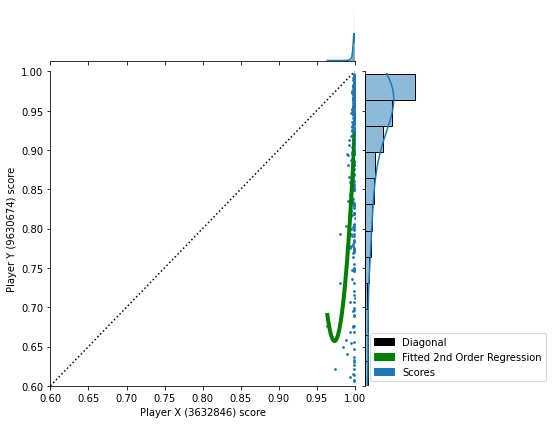

In [5]:
# Plot 1st and 2nd user in year 2017 (defaults)
# Note that this is a cropped graph! From 600K to 1M
_ = plot_user_pair(df, lim=(0.6, 1))

## Interpretation of Pair Plot

Three things:
- **Scatter Plot**: All points are **squished** to the right
- **Histogram**: Many points lean towards 1 in the X Axis. (1 Million Score)
- **Regression**: The 2nd order plot is not one-to-one. It also has a minima.

### Scatter Plot Squishing

Take a point from the bottom-right, Player X played much better than Player Y.
This can't be said for the other player.

We plot a diagonal here too, if many points lie on one side of the triangle, we conclude that one is better than the other.

### Histogram Squishing

Consistent with the above, the histogram is squished for Player X, while Y spans a wide range.

We can say that Player X played many higher scores than Y, and is consistently better in those maps.

- Note that the maps chosen uses an INNER JOIN, thus we may not see poor scores from Player X as it's out of reach by Player Y.

### Regression Minima

By theory, if a map is easier, both Player A & B should perform better.
Translating it to our graph, a point further top right indicates an easier map.

Thus, it would make sense that the scores are mapped to a one-to-one function, where the minimum is at (0, 0), maximum at (1, 1).
- One to One as a single score from either Player X or Y should associate with only 1 score from the other player
- (0, 0) implies that the map is extremely hard, players scored 0
- (1, 1) implies that the map is extremely easy, players scored 1 (1 Million).

Our regression isn't able to do so, as it's not guaranteed to pass through (0, 0), (1, 1).

---

It's a lot to do, let's solve them one by one:

- **Score Uniformity**: The plot is too squished on higher scores, we can make it uniform
- **Custom Function Regression**: 2nd Order Regression won't work as the intercepts aren't guaranteed & it may create unwanted minimums.

## Score Uniformity
Let's backtrack a bit and analyse the score distribution.

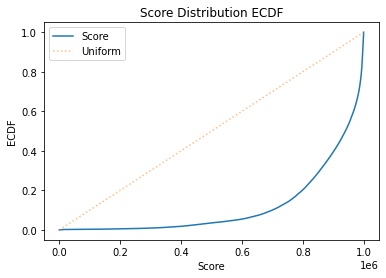

In [6]:
from opal.utils import ecdf

cdf = ecdf(df.score)
cdf.plot(label='Score')
plt.plot([0, 1e6], [0, 1], linestyle='dotted', alpha=0.5, label='Uniform')
plt.xlabel("Score")
plt.ylabel("ECDF")
plt.title("Score Distribution ECDF")
_ = plt.legend()

We see that the distribution skews to extremely high scores, consistent with what we observed prior!

Ideally, we want a uniform distribution ECDF as the goal, which is plotted too.

We have some transforms that can work, namely `QuantileTransform`

In [7]:
from sklearn.preprocessing import QuantileTransformer
import warnings

# A false positive set by slice warning is shown, silence it
warnings.filterwarnings('ignore')

qt = QuantileTransformer()
df.loc[:, 'score_transformed'] = qt.fit_transform(df.loc[:, ['score']]) * 1e6

Take a look at the transformed ECDF

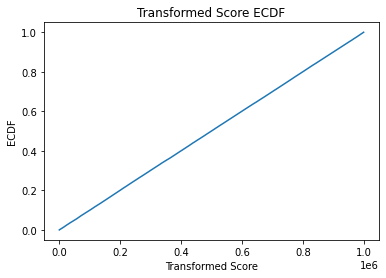

In [8]:
cdf_transformed = ecdf(df['score_transformed'])
cdf_transformed.plot(label='Transformed Score')
plt.title("Transformed Score ECDF")
plt.xlabel("Transformed Score")
_ = plt.ylabel("ECDF")

Looks good, let's plot with the transformed score

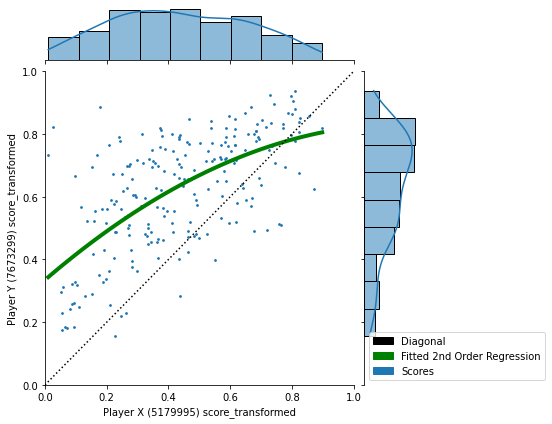

In [9]:
_ = plot_user_pair(df, 4, 5, lim=[0, 1], score_col='score_transformed')

### Results of Score Uniformity

Looks great! By spreading the data, we have a better spread of points to perform regression on.

## x^exp(a) Regression

The x^exp(a) graph is an interesting one, let's take it look at it here.

We vary `a` and plot the graphs.

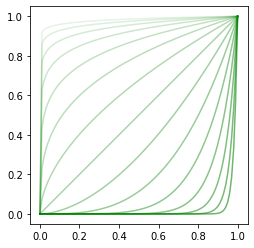

In [10]:
x = np.linspace(0, 1, 100)
for e, a in enumerate(np.linspace(-4, 4, 15)):
    _ = plt.plot(x, x ** np.exp(a), color='green', alpha=0.1 + (e / 15 / 2))
_ = plt.gca().set_aspect('equal', adjustable='box')

It's aesthetically pleasing, and perfect for our purposes.

- It fixes minima at 0
- It fixes maxima at 1
- It changes concavity with `a`
- It is valid for **ALL** `a`!

Notice that for a = 0 it's a straight diagonal.

### Curve fitting x^exp(a)

We will use `curve_fit` to fit and plot out the fit.

In [11]:
from scipy.optimize import curve_fit


def plot_user_pair_xexpa(*args, **kwargs):
    df_pair = plot_user_pair(*args, **kwargs)
    plt.close()  # Don't show plot for this

    def fn(x, a):
        return x ** (np.exp(a))

    est_a, error = curve_fit(fn, df_pair['score_transformed_x'], df_pair['score_transformed_y'])
    plt.scatter(df_pair['score_transformed_x'], df_pair['score_transformed_y'], s=3, alpha=0.5)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x ** (np.exp(est_a)), alpha=0.8, color='green')
    plt.gca().set_aspect('equal', adjustable='box')
    return est_a[0]

Predicted Alpha:  -0.6952837380837187


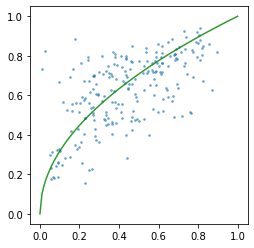

In [12]:
est_a = plot_user_pair_xexpa(df, 4, 5, 2017, score_col='score_transformed')
print("Predicted Alpha: ", est_a)

Predicted Alpha:  3.1471553330015656


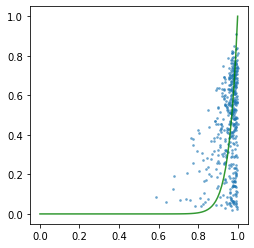

In [13]:
est_a = plot_user_pair_xexpa(df, 0, 1, 2017, score_col='score_transformed')
print("Predicted Alpha: ", est_a)

### Rating Similarity

Ultimately we want a similarity measure, we want to weight values close 0 high, those further lower.
I propose the following curve.

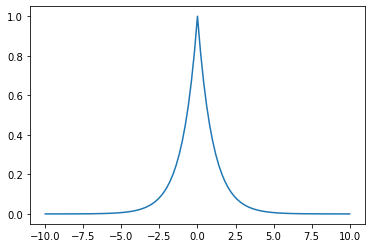

In [14]:
x = np.linspace(-10, 10, 101)
b = 2


def similarity(alpha):
    return np.exp(-np.abs(alpha))


plt.plot(x, similarity(x))

Predicted Similarity:  0.4989328616453


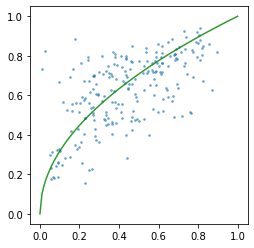

In [15]:
est_a = plot_user_pair_xexpa(df, 4, 5, 2017, score_col='score_transformed')
print("Predicted Similarity: ", similarity(est_a))

Predicted Similarity:  0.04297420044517152


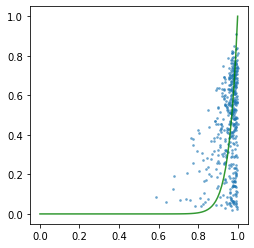

In [16]:
est_a = plot_user_pair_xexpa(df, 0, 1, 2017, score_col='score_transformed')
print("Predicted Similarity: ", similarity(est_a))

Brilliant! Now we have a way to find similarity between players

## Summary

In this notebook, we covered the foundational EDA for our score data.
Furthermore, we found a way to calculate similarity between 2 scores:
- We `QuantileTransformed` the score for uniformity
- We then used a custom function to `curve_fit`
- Finally, we transformed our predicted variable `a` (alpha) to a similarity score!